In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

/var/folders/25/82ztpk21087b258r7gs0n3m00000gn/T/ipykernel_2477/859329180.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Overview



### Part 1: Priming the data

Different datasets have certain marker values associated with certain locations at different levels (e.g., the neighbourhood level or sub-district level). These values are essential for merging datasets (for example, one dataset may contain a neighbourhood's number of cars, and another a tree and which neighbourhood it is in)

Not every dataset uses the same marker values, and these marker values can have different column names, so I first need to standardise it all. I'm also making some functions that will streamline the data cleaning process a bit.

In [3]:
# functions for data cleaning
# return the proportion of nan each column in the data
def na_proportion(series: pd.Series):
    return series.isna().sum() / len(series)

# returns a dataframe without the columns that have higher proportion of na 
# than threshold. The reason I'm doing this is because drop.na could remove
# very large amounts of data just due to one a column being mostly nans. So
# columns full of nans get removed. 
# default threshold: 40% of nan means removal
def stripped_threshold_na_columns(df: pd.DataFrame, threshold = 0.4):
    df_return = pd.DataFrame()
    for column in df.columns:
        if na_proportion(df[column]) < threshold:
            df_return[column] = df[column]
    return df_return

# if a value occurs less than n times in a series, replace it with placeholder
def replace_less_than_n_values(series: pd.Series, n = 10, placeholder = np.nan):
    value_counts = series.value_counts()
    values_to_replace = value_counts[value_counts < n].index
    return series.replace(to_replace=values_to_replace, value=placeholder)

# returns the n most common values in a series (by default the 10 most common)
def most_common_n_values(series: pd.Series, n = 10):
    return series.value_counts()[:n].index.tolist()


# return a series with its least common values converted to a different value
# nans are also replaceable
# by default, the string 'other'
def otherise(value, most_common_values, other, nan_replace):
    if value in most_common_values:
        return value
    if value is np.nan:
        return nan_replace
    return other

def otherise_less_common_values(
        series: pd.Series, 
        most_common_values, 
        other='other', 
        nan_replace = np.nan
    ):
    return series.apply(
        lambda value: otherise(value, most_common_values, other, nan_replace)
    )


In [4]:
# tree data
df_trees = pd.read_csv('data/bomen-stamgegevens-2024-03-12T09 06 04.036291.csv')
# amsterdam neighbourhood meta data, i.e. matching neighbourhood name with ID
df_buurt_meta = pd.read_csv('data/gebieden-buurten-2024-03-12T12 09 07.653588.csv')
# amsterdam sub-district meta data, to match each neighbourhood with its district
df_wijk_meta = pd.read_csv('data/gebieden_wijken.csv')

In [5]:
# standardise names of neighbourhood id column so we can merge on that column
buurt_id_column = 'buurt_id'
wijk_id_column = 'wijk_id'

# rename buurt id columns in all datasets to be the same for merging
df_buurt_meta = df_buurt_meta.rename(
    columns={'Identificatie': buurt_id_column}
)
df_trees = df_trees.rename(
    columns={'Gbdbuurtid': buurt_id_column}
)

# rename wijk id columns in all datasets to be the same for merging
df_buurt_meta = df_buurt_meta.rename(
    columns={'Ligtinwijkid': wijk_id_column}
)
df_wijk_meta = df_wijk_meta.rename(
    columns={'Identificatie': wijk_id_column}
)


In [6]:
# match each buurt (neighbourhood) with its associated wijk (sub-district)
df_buurt_simple = df_buurt_meta[[
    buurt_id_column, wijk_id_column, 'Naam', 'Code', 'Cbscode', 'Geometrie'
]]

df_buurt_simple = df_buurt_simple.rename(
    columns={
        'Naam': 'Naam_buurt',
        'Code': 'Code_buurt',
        'Cbscode': 'Cbscode_buurt',
        'Geometrie': 'Geometrie_buurt'
    }
)

df_wijk_simple = df_wijk_meta[[
    wijk_id_column, 'Naam', 'Code', 'Cbscode', 'Geometrie'
]]

df_wijk_simple = df_wijk_simple.rename(
    columns={
        'Naam': 'Naam_wijk',
        'Code': 'Code_wijk',
        'Cbscode': 'Cbscode_wijk',
        'Geometrie': 'Geometrie_wijk'
    }
)

df_location_data = pd.merge(df_buurt_simple, df_wijk_simple, on=wijk_id_column)

Now we can merge datasets based on shared location markers. Yay!

### Part 2: Tree data

I am making a dataset which contains a list of trees from Amsterdam's tree census and some information associated with each tree. This is the cleaning up of that data.

#### Removing columns with too many nans, then removing nans
To prevent removing too much data, I'm discarding columns that have too many nans (the diameter column for example), making exceptions only for interesting data.

Then I remove any row with a nan value for the model.

It's possible that I'm skewing the data in a way that will affect my model (example: maybe there is a specific relationship between height and species that's only found in trees that also have a nan value somewhere) but I don't have time to look at that and it's probably beyond the requirements of the assignment.

In [7]:
# clean up tree data
# removing nans
# we want to remove columns that have too many nans so that we don't reduce
# the entire dataset too much by using .dropna
# I make exceptions for growth ground and diameter statistics since these seem
# useful for certain models
growth_ground = df_trees['Standplaatsgedetailleerd']
diameter = df_trees['Stamdiameterklasse']

print(f'shape before dropna: {df_trees.shape}')

df_trees = stripped_threshold_na_columns(df_trees)
df_trees['growth_ground'] = growth_ground
df_trees['diameter'] = diameter
df_trees.dropna(inplace=True)

print(f'shape after dropna: {df_trees.shape}')


nan proportion Standplaatsgedetailleerd 0.620510336029891
shape before dropna: (286909, 14)
shape after dropna: (28211, 14)


#### Height data

Height data is unfortunately not recorded exactly but given as an estimated range (like "between 6 and 9").

I'm going to store height in two ways: in one instance I will take the average (so between 6 and 9 gives me 7.5), in anotehr instance I will take a random value (so a random value between 6 and 9).

I will try running a model for both the "fixed" value and the "random" values, I am curious what that will result in.

In [8]:
# height
# we only have estimation measures for tree height (like "6 tot 9 m.") :(
# There are some limitations from applying a linear regression model
# to height that is calculated this way.
def extract_height_data(data):
    if data == 'a. tot 6 m.':
        return 3
    if data == 'b. 6 tot 9 m.':
        return 7.5
    if data == 'c. 9 tot 12 m.':
        return 10.5
    if data == 'd. 12 tot 15 m.':
        return 13.5
    if data == 'e. 15 tot 18 m.':
        return 16.5
    if data == 'f. 18 tot 24 m.':
        return 21
    if data == 'g. 24 m. en hoger':
        return 24
    # if not any of the above return nan
    return np.nan

df_trees['tree_height_fixed'] = df_trees['Boomhoogteklasseactueel'].apply(
    lambda x: extract_height_data(x)
)

df_trees.dropna(inplace=True)




In [9]:
import random
def extract_height_data_randomised(data):
    if data == 'a. tot 6 m.':
        return random.uniform(0, 6)
    if data == 'b. 6 tot 9 m.':
        return random.uniform(6, 9)
    if data == 'c. 9 tot 12 m.':
        return random.uniform(9, 12)
    if data == 'd. 12 tot 15 m.':
        return random.uniform(12, 15)
    if data == 'e. 15 tot 18 m.':
        return random.uniform(15, 18)
    if data == 'f. 18 tot 24 m.':
        return random.uniform(18, 24)
    if data == 'g. 24 m. en hoger':
        return random.uniform(24, 30)
    # if not any of the above return nan
    return np.nan

df_trees['tree_height_random'] = df_trees['Boomhoogteklasseactueel'].apply(
    lambda x: extract_height_data_randomised(x)
)

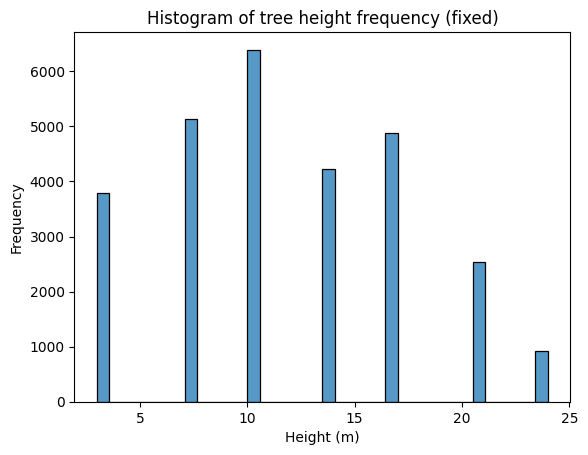

In [10]:
sns.histplot(df_trees['tree_height_fixed'])
plt.title("Histogram of tree height frequency (fixed)")
plt.xlabel("Height (m)")
plt.ylabel("Frequency")# visualise tree height distribution
plt.show()


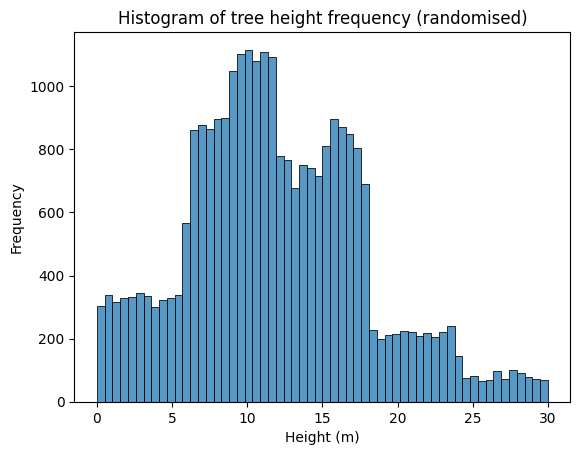

In [11]:
sns.histplot(df_trees['tree_height_random'])
plt.title("Histogram of tree height frequency (randomised)")
plt.xlabel("Height (m)")
plt.ylabel("Frequency")# visualise tree height distribution
plt.show()


##### Shape of height data

It looks like a left-skewed, normal-ish distribution. I would guess that if the data contained the actual height of trees, the data would look a bit more like a normal distribution.

### Diameter
Similar cleaning process for diameter

In [34]:
df_trees['diameter'].value_counts()

diameter
0,1 tot 0,2 m.    8625
0,3 tot 0,5 m.    7246
0,2 tot 0,3 m.    6549
0,5 tot 1 m.      3774
1,0 tot 1,5 m.     295
Name: count, dtype: int64

In [ ]:
def extract_diameter_data(diameter):
    if diameter == '0,1 tot 0,2 m.':
        return 0.15
    if diameter == '0,2 tot 0,3 m.':
        return 0.25
    if diameter == '0,3 tot 0,5 m.':
        return 0.4
    if diameter == '0,5 tot 1 m.':
        return 0.75
    if diameter == '1,0 tot 1,5 m.':
        return 1.25

df_trees['diameter'] = df_trees['diameter'].apply(
    lambda x: extract_diameter_data(x)
)

df_trees['diameter'].value_counts()

In [12]:
# neighbourhood that tree is in (ID)
print(df_trees['buurt_id'].value_counts())

buurt_id
3.630980e+12    1880
3.630980e+12    1111
3.630980e+12     820
3.630980e+12     653
3.630980e+12     615
                ... 
3.630980e+12       1
3.630980e+12       1
3.630980e+12       1
3.630980e+12       1
3.630980e+12       1
Name: count, Length: 250, dtype: int64


In [13]:
# tree administrator ('Typebeheerderplus')
# categorical
print(df_trees['Typebeheerderplus'].value_counts())
admin_threshold = 15
df_trees['tree_admin'] = replace_less_than_n_values(
    df_trees['Typebeheerderplus'],
    admin_threshold
)
print(f'proportion of nan for admin after removal: {na_proportion(df_trees['Typebeheerderplus'])}')

df_trees.dropna(inplace=True)

Typebeheerderplus
R&E_VOR_Bomen                     26264
Recreatieschap Noord-Holland       1384
R&E_VOR_Groen                        82
Gemeente Amsterdam, rve Sport        74
Rijkswaterstaat                      24
Gemeentelijk Vastgoed                17
Stichting                             8
Havenbedrijf                          6
Amsterdamse bos - eigen dienst        4
Volkstuinpark                         3
Woningcorporatie                      2
Schooltuinen                          1
Natuurlijk persoon                    1
Name: count, dtype: int64
proportion of nan for admin after removal: 0.0


In [14]:
print(df_trees['tree_admin'].value_counts())

tree_admin
R&E_VOR_Bomen                    26264
Recreatieschap Noord-Holland      1384
R&E_VOR_Groen                       82
Gemeente Amsterdam, rve Sport       74
Rijkswaterstaat                     24
Gemeentelijk Vastgoed               17
Name: count, dtype: int64


In [15]:
# municipality that owns the trees
print(df_trees['Typeeigenaarplus'].value_counts())
# the overwhelming majority of trees are owned by amsterdam.
# let's have values for just "amsterdam" and "not amsterdam"
amsterdam_ownership = ['Gemeente Amsterdam']
df_trees['tree_municipality'] = otherise_less_common_values(
    df_trees['Typeeigenaarplus'], amsterdam_ownership
)

Typeeigenaarplus
Gemeente Amsterdam       25498
Gemeente Weesp            2332
Gemeente Diemen              8
Gemeente Ouder-Amstel        7
Name: count, dtype: int64


In [16]:
df_trees['tree_municipality'].value_counts()

tree_municipality
Gemeente Amsterdam    25498
other                  2347
Name: count, dtype: int64

In [17]:
# tree planting year
print(
    f'proportion of nan for planting year: {na_proportion(df_trees['Jaarvanaanleg'])}'
)
# not many nans :)
print(df_trees['Jaarvanaanleg'].value_counts())
# lots of zeros :(
# Removing all the rows with nonsensical years
year_threshold = 1500 # let's admit really old trees because they are awesome
df_trees = df_trees[df_trees.Jaarvanaanleg > year_threshold]
df_trees.rename(columns={
    'Jaarvanaanleg': 'year_planted'
}, inplace=True)


proportion of nan for planting year: 0.0
Jaarvanaanleg
1980.0    1708
1970.0    1603
1985.0    1590
1996.0    1392
1990.0    1101
          ... 
1929.0       1
1880.0       1
1924.0       1
2022.0       1
1934.0       1
Name: count, Length: 114, dtype: int64


In [18]:
df_trees['age'] = 2024 - df_trees['year_planted']

<Axes: xlabel='age', ylabel='Count'>

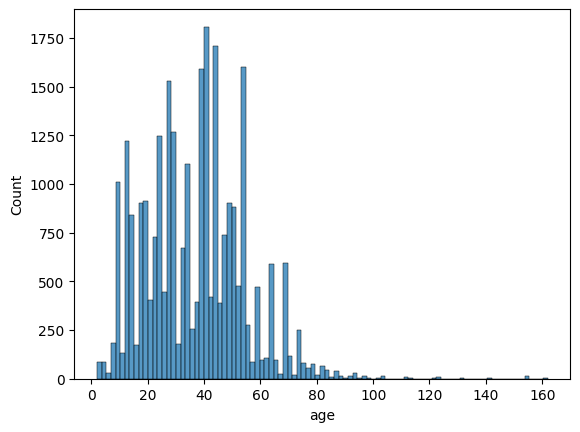

In [19]:
sns.histplot(df_trees['age'])

In [20]:
# there are three columns for the species of the tree
# Soortnaam: specific latin name species
print(df_trees['Soortnaam'].value_counts())
# Sortnaamkort/Sortnaamtop are for grouped species (they're the same)
print(f'nan proportion Soortnaamkort: {na_proportion(df_trees['Soortnaamkort'])}')
print(df_trees['Soortnaamkort'].value_counts())
print(f'nan proportion Soortnaamtop: {na_proportion(df_trees['Soortnaamtop'])}')
print(df_trees['Soortnaamtop'].value_counts())

# let's choose both, even if they will by definition be highly correlated in some ways

Soortnaam
Fraxinus excelsior           953
Alnus glutinosa              929
Quercus robur                917
Platanus hispanica           819
Ulmus hollandica 'Vegeta'    780
                            ... 
Malus atrosanguinea            1
Malus 'Butterball'             1
Catalpa ovata                  1
Acer pensylvanicum             1
Morus alba 'Pendula'           1
Name: count, Length: 568, dtype: int64
nan proportion Soortnaamkort: 0.0
Soortnaamkort
Tilia        3735
Ulmus        3354
Acer         2803
Fraxinus     2371
Alnus        1631
             ... 
Aralia          1
Toona           1
Hibiscus        1
Tetradium       1
Nyssa           1
Name: count, Length: 72, dtype: int64
nan proportion Soortnaamtop: 0.0
Soortnaamtop
Linde (Tilia)     3735
Iep (Ulmus)       3354
Esdoorn (Acer)    2803
Es (Fraxinus)     2371
Els (Alnus)       1631
                  ... 
Aralia               1
Hibiscus             1
Tetradium            1
Nyssa                1
Frangula             1
Name:

In [21]:
# Soortnaam (exact species)
# How many species are there?
print(f'number of species: {df_trees['Soortnaam'].value_counts().shape}')
# let's remove trees which species there are too few of
species_threshold = 10
df_trees['species'] = replace_less_than_n_values(
    df_trees['Soortnaam'],
    species_threshold
)
# how much did that remove?
print(f'number of species after removal: {df_trees['species'].value_counts().shape}')
print(f'nan proportion Soortnaam after removal: {na_proportion(df_trees['species'])}')
df_trees.dropna(inplace=True)

number of species: (568,)
number of species after removal: (242,)
nan proportion Soortnaam after removal: 0.03937350445943006


In [22]:
# Soortnaamkort (species group)
# How many groups are there?
print(f'number of species groups: {df_trees['Soortnaamkort'].value_counts().shape}')
# proportion of nan?
print(f'nan proportion Soortnaamkort: {na_proportion(df_trees['Soortnaamkort'])}')
# let's remove trees which species group there are too few of
gr_species_threshold = 10
df_trees['species_group'] = replace_less_than_n_values(
    df_trees['Soortnaamkort'],
    gr_species_threshold
)
# how much did that remove?
print(f'number of species groups after removal: {df_trees['species_group'].value_counts().shape}')
print(f'nan proportion species_group after removal: {na_proportion(df_trees['species_group'])}')
df_trees.dropna(inplace=True)


number of species groups: (47,)
nan proportion Soortnaamkort: 0.0
number of species groups after removal: (47,)
nan proportion species_group after removal: 0.0


In [23]:
# Typeobject (status of the object)
print(f'{df_trees['Typeobject'].value_counts()}')
# seems fine already. will just nan up the one boomstam_algemeen
df_trees['tree_treatment'] = replace_less_than_n_values(df_trees['Typeobject'])
df_trees.dropna(inplace=True)

Typeobject
Boom niet vrij uitgroeiend    22269
Boom vrij uitgroeiend          2314
Knotboom                        637
Gekandelaberde boom             515
Vormboom                        460
Stobbe                          296
Leiboom                           5
Name: count, dtype: int64


In [24]:
# Typesoortnaam (the sort of thing that this is)
print(df_trees['Typesoortnaam'].value_counts())
# we are only interested in trees
only_trees = most_common_n_values(df_trees['Typesoortnaam'], n = 1)
df_trees['plant_type'] = otherise_less_common_values(
    df_trees['Typesoortnaam'],
    only_trees,
    other = np.nan
)
df_trees.dropna(inplace=True)

Typesoortnaam
Bomen       26489
Algemeen        2
Name: count, dtype: int64


In [25]:
# number of trees left
print(df_trees.shape)

(26489, 23)


In [26]:
df_with_location = pd.merge(df_trees, df_location_data, on=buurt_id_column)
display(df_with_location.sample(10).head())
print(df_with_location.columns)

,Id,buurt_id,Geometrie,Typebeheerderplus,Boomhoogteklasseactueel,Typeeigenaarplus,year_planted,Soortnaam,Typeobject,Typesoortnaam,...,plant_type,wijk_id,Naam_buurt,Code_buurt,Cbscode_buurt,Geometrie_buurt,Naam_wijk,Code_wijk,Cbscode_wijk,Geometrie_wijk
18447,1112279,3.630980e+12,SRID=28992;POINT (121117.48 491354.02),R&E_VOR_Bomen,e. 15 tot 18 m.,Gemeente Amsterdam,1970.0,Populus canescens,Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000088,Tuindorp Oostzaan-Oost,NC02,BU0363NC02,"SRID=28992;POLYGON ((121575.334 492121.98, 121...",Tuindorp Oostzaan,NC,WK0363NC,"SRID=28992;POLYGON((121989.715 491718.467,1218..."
15381,1086736,3.630980e+12,SRID=28992;POINT (121200.39 491210.54),R&E_VOR_Bomen,d. 12 tot 15 m.,Gemeente Amsterdam,1985.0,Ulmus 'Lobel',Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000087,Cornelis Douwesterrein-Oost,NB02,BU0363NB02,"SRID=28992;POLYGON ((120480.265 491847.587, 12...",Noordelijke IJ-oevers-West,NB,WK0363NB,"SRID=28992;POLYGON((121339.542 491141.159,1213..."
21735,1126529,3.630980e+12,SRID=28992;POINT (112933.71 488180.72),Recreatieschap Noord-Holland,c. 9 tot 12 m.,Gemeente Amsterdam,2011.0,Salix alba,Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000041,Osdorper Binnenpolder,FB01,BU0363FB01,"SRID=28992;POLYGON ((114160.397 488670.845, 11...",Geuzenveld,FB,WK0363FB,"SRID=28992;POLYGON((115657.535 488104.019,1156..."
14286,1078419,3.630980e+12,SRID=28992;POINT (122593.65 490362.8),R&E_VOR_Bomen,b. 6 tot 9 m.,Gemeente Amsterdam,1990.0,Acer pseudoplatanus,Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000095,Bloemenbuurt-Noord,NK01,BU0363NK01,"SRID=28992;POLYGON ((122851.828 490445.054, 12...",Volewijck,NK,WK0363NK,"SRID=28992;POLYGON((123288.378 489738.364,1233..."
14207,1078134,3.630980e+12,SRID=28992;POINT (113877.4 490135.2),R&E_VOR_Bomen,c. 9 tot 12 m.,Gemeente Amsterdam,1995.0,Ulmus 'New Horizon',Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000040,Sloterdijk Poort-Noord,FA02,BU0363FA02,"SRID=28992;POLYGON ((115129.692 490371.221, 11...",Sloterdijk Nieuw-West,FA,WK0363FA,"SRID=28992;POLYGON((115688.525 489818.057,1156..."


Index(['Id', 'buurt_id', 'Geometrie', 'Typebeheerderplus',
       'Boomhoogteklasseactueel', 'Typeeigenaarplus', 'year_planted',
       'Soortnaam', 'Typeobject', 'Typesoortnaam', 'Soortnaamkort',
       'Soortnaamtop', 'growth_ground', 'diameter', 'tree_height_fixed',
       'tree_height_random', 'tree_admin', 'tree_municipality', 'age',
       'species', 'species_group', 'tree_treatment', 'plant_type', 'wijk_id',
       'Naam_buurt', 'Code_buurt', 'Cbscode_buurt', 'Geometrie_buurt',
       'Naam_wijk', 'Code_wijk', 'Cbscode_wijk', 'Geometrie_wijk'],
      dtype='object')


In [27]:
# parking data
df_parking = pd.read_csv('data/parking_data_amsterdam.csv')


In [28]:
# some info about this dataset
print(f'shape of parking dataset: {df_parking.shape}')
print(f'columns: {df_parking.columns}')
parking_count_per_buurt = df_parking['buurtcode'].value_counts()
parking_per_neighbourhood = pd.DataFrame({
    'Code_buurt': parking_count_per_buurt.index,
    'parked_cars_in_neighbourhood': parking_count_per_buurt.values
})
print(parking_per_neighbourhood)


shape of parking dataset: (266622, 9)
columns: Index(['WKT', 'id', 'buurtcode', 'straatnaam', 'type', 'soort', 'e_type',
       'aantal', 'versiedatum'],
      dtype='object')
    Code_buurt  parked_cars_in_neighbourhood
0         KQ05                          2986
1         KR03                          2385
2         FH02                          2373
3         FA03                          2348
4         MN03                          2231
..         ...                           ...
497       AD08                             7
498       TA05                             6
499       NQ07                             4
500       FN03                             4
501       MP02                             2

[502 rows x 2 columns]


In [29]:
df_with_parking = pd.merge(
    df_with_location, 
    parking_per_neighbourhood,
    on='Code_buurt'
)
df_with_parking.dropna(inplace=True)
display(df_with_parking.sample(10).head())

,Id,buurt_id,Geometrie,Typebeheerderplus,Boomhoogteklasseactueel,Typeeigenaarplus,year_planted,Soortnaam,Typeobject,Typesoortnaam,...,wijk_id,Naam_buurt,Code_buurt,Cbscode_buurt,Geometrie_buurt,Naam_wijk,Code_wijk,Cbscode_wijk,Geometrie_wijk,parked_cars_in_neighbourhood
18095,1116934,3.630980e+12,SRID=28992;POINT (113402.15 484791.06),R&E_VOR_Bomen,d. 12 tot 15 m.,Gemeente Amsterdam,1961.0,Acer pseudoplatanus,Boom niet vrij uitgroeiend,Bomen,...,3630970000046,De Aker-West,FG02,BU0363FG02,"SRID=28992;POLYGON ((113120.738 485391.253, 11...",De Aker,FG,WK0363FG,"SRID=28992;POLYGON((114441.219 485181.601,1144...",1736
23283,1276897,3.630980e+12,SRID=28992;POINT (132056.872119784 479522.2559...,R&E_VOR_Bomen,c. 9 tot 12 m.,Gemeente Weesp,2008.0,Pyrus calleryana 'Chanticleer',Boom niet vrij uitgroeiend,Bomen,...,3630970000104,Weesp-Zuid II,SD05,BU0363SD05,"SRID=28992;POLYGON ((131888.906 479790.688, 13...",Weesp Binnenstad/Zuid,SD,WK0363SD,"SRID=28992;POLYGON((131888.906 479790.688,1318...",326
20419,1126501,3.630980e+12,SRID=28992;POINT (112535 488060.13),R&E_VOR_Bomen,d. 12 tot 15 m.,Gemeente Amsterdam,1996.0,Alnus spaethii 'Spaeth',Boom niet vrij uitgroeiend,Bomen,...,3630970000045,Osdorper Bovenpolder,FF01,BU0363FF01,"SRID=28992;POLYGON ((112232.693 488304.895, 11...",Lutkemeer/Ookmeer,FF,WK0363FF,"SRID=28992;POLYGON((115370.192 487357.932,1150...",104
14421,1089742,3.630980e+12,SRID=28992;POINT (113873.58 484710.49),R&E_VOR_Bomen,c. 9 tot 12 m.,Gemeente Amsterdam,2000.0,Prunus avium 'Plena',Boom niet vrij uitgroeiend,Bomen,...,3630970000046,De Aker-West,FG02,BU0363FG02,"SRID=28992;POLYGON ((113120.738 485391.253, 11...",De Aker,FG,WK0363FG,"SRID=28992;POLYGON((114441.219 485181.601,1144...",1736
9383,1026597,3.630980e+12,SRID=28992;POINT (123746.33 484168.25),R&E_VOR_Bomen,a. tot 6 m.,Gemeente Amsterdam,1970.0,Malus 'Aldenhamensis',Boom niet vrij uitgroeiend,Bomen,...,3630970000082,De Wetbuurt,MM07,BU0363MM07,"SRID=28992;POLYGON ((123675.044 484395.005, 12...",Frankendael,MM,WK0363MM,"SRID=28992;POLYGON((124540.644 484524.221,1245...",873


Text(0, 0.5, 'Frequency')

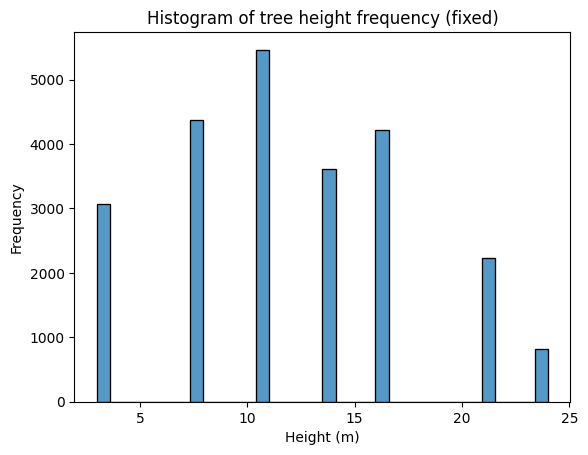

In [30]:
# let's plot the height of trees of the cleaned up dataset
sns.histplot(df_with_parking['tree_height_fixed'])
plt.title("Histogram of tree height frequency (fixed)")
plt.xlabel("Height (m)")
plt.ylabel("Frequency")

In [31]:
# last cleaning steps to make dataset smaller
df_with_parking.columns

Index(['Id', 'buurt_id', 'Geometrie', 'Typebeheerderplus',
       'Boomhoogteklasseactueel', 'Typeeigenaarplus', 'year_planted',
       'Soortnaam', 'Typeobject', 'Typesoortnaam', 'Soortnaamkort',
       'Soortnaamtop', 'growth_ground', 'diameter', 'tree_height_fixed',
       'tree_height_random', 'tree_admin', 'tree_municipality', 'age',
       'species', 'species_group', 'tree_treatment', 'plant_type', 'wijk_id',
       'Naam_buurt', 'Code_buurt', 'Cbscode_buurt', 'Geometrie_buurt',
       'Naam_wijk', 'Code_wijk', 'Cbscode_wijk', 'Geometrie_wijk',
       'parked_cars_in_neighbourhood'],
      dtype='object')

In [32]:
# removing redundant columns
columns_to_drop = ['Id', 'buurt_id', 'Geometrie', 'Typebeheerderplus', 
                   'Boomhoogteklasseactueel', 'Typeeigenaarplus', 'year_planted',
                    'Soortnaam', 'Typeobject', 'Typesoortnaam', 'Soortnaamkort',
                    'Soortnaamtop', 'wijk_id', 'Code_buurt', 'Cbscode_buurt',
                    'Geometrie_buurt', 'Code_wijk', 'Cbscode_wijk',
                    'Geometrie_wijk', 'plant_type'
]
df_trees_final = df_with_parking.drop(columns=columns_to_drop)

In [33]:
df_trees_final.to_csv('data/clean_tree_data.csv')